In [362]:
#  Phase 1: Python – Data Cleaning, Preprocessing & EDA--Desriptive Analysis


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 





In [364]:
#Step 1: Load and Merge Datasets

# load and combine split files

# Load and combine customers
# Load CSV parts
customers = pd.concat([
    pd.read_csv('customers_part1.csv'),
    pd.read_csv('customers_part2.csv')
], ignore_index=True)

financials = pd.concat([
    pd.read_csv('financials_part1.csv'),
    pd.read_csv('financials_part2.csv')
], ignore_index=True)

claims = pd.concat([
    pd.read_csv('claims_part1.csv'),
    pd.read_csv('claims_part2.csv')
], ignore_index=True)

# Merge datasets
cust_fin = pd.merge(customers, financials, on='customer_id', how='inner')
master_df = pd.merge(cust_fin, claims, on='customer_id', how='left')

In [418]:
#Step 2: Handle Missing Data


# Check missing values
missing_Data = master_df.isnull().sum()
print(missing_Data)
# check null count
Null_Count=master_df.info()
print(Null_Count)

# Drop rows with critical missing values
master_df = master_df.dropna(subset=['credit_score', 'income', 'loan_amount'])

# Optional: Fill non-critical missing values
master_df['claim_status'] = master_df['claim_status'].fillna('Unknown')





customer_id                0
name                       0
age                        0
income                     0
employment_status          0
region                     0
signup_date                0
loan_amount                0
credit_score               0
late_payments              0
default_history            0
risk_score                 0
risk_level                 0
claim_id                7326
incident_date           7326
claim_amount            7326
claim_status               0
claim_type              7326
debt_to_income_ratio       0
risk_category              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27410 entries, 0 to 27409
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           27410 non-null  int64  
 1   name                  27410 non-null  object 
 2   age                   27410 non-null  int64  
 3   income                27410 non-null  

In [372]:
#Validation after concat for data parts
print("\nCustomer_Details")
print(customers.shape)  # Check total rows and columns
print(customers['customer_id'].nunique())  # Ensure no duplicate IDs
print("\nClaims_Details")
print(claims.shape)
print(claims['customer_id'].nunique())
print("\nfinancials_Details")
print(financials.shape) # Check total rows and columns
print(financials['customer_id'].nunique())


Customer_Details
(20000, 7)
20000

Claims_Details
(20000, 6)
12691

financials_Details
(20000, 7)
12670


In [428]:
##Step 3: Detect and Correct Data Inconsistencies



#Negative Income in customers.csv (Row 101)
#Income should never be negative. A value like -10000 likely reflects a data entry mistake and its known data issue .
# Converting negative income to positive using abs()

customers['income'] = customers['income'].apply(lambda x: abs(x) if x < 0 else x)





# Cap invalid credit scores
#Invalid Credit Score in financials.csv (Row 201)
#Credit scores typically range from 300 to 850. A score of 999 is invalid.
#so 

financials['credit_score'] = pd.to_numeric(financials['credit_score'], errors='coerce')
financials['credit_score'] = financials['credit_score'].apply(lambda x: min(x, 850) if x > 850 else x)


# Fix negative claim amounts
#Negative Claim Amount in claims.csv (Row 301)
# Claim amounts should be positive. A value like -5000 is likely a reversal or entry error.


claims['claim_amount'] = claims['claim_amount'].apply(lambda x: abs(x) if x < 0 else x)






In [448]:
# Loan amounts should never be negative. A negative loan amount would imply the customer is somehow “giving” money to the lender,
#which doesn't make sense



master_df['loan_amount'] = master_df['loan_amount'].apply(lambda x: abs(x) if x < 0 else x)

negative_loans = master_df[master_df['loan_amount'] < 0]
print(negative_loans[['customer_id', 'loan_amount']])




Empty DataFrame
Columns: [customer_id, loan_amount]
Index: []


In [450]:
# Validation for of known issues
issue_log = {
    'negative_income_rows': customers[customers['income'] < 0].index.tolist(),
    'invalid_credit_score_rows': financials[financials['credit_score'] > 850].index.tolist(),
    'negative_claim_amount_rows': claims[claims['claim_amount'] < 0].index.tolist()
}
print(issue_log)


{'negative_income_rows': [], 'invalid_credit_score_rows': [], 'negative_claim_amount_rows': []}


In [432]:
##Step 5: Feature Engineering


master_df['income'] = pd.to_numeric(master_df['income'], errors='coerce')
master_df['loan_amount'] = pd.to_numeric(master_df['loan_amount'], errors='coerce')

# Replace zero or missing income to avoid division errors
master_df['income'] = master_df['income'].replace(0, np.nan)

#  Feature Engineering: Debt-to-Income Ratio
master_df['debt_to_income_ratio'] = master_df['loan_amount'] / master_df['income']
# Risk category based on credit score
def categorize_risk(credit_score):
    if credit_score < 550:
        return 'High Risk'
    elif credit_score < 650:
        return 'Medium Risk'
    elif credit_score < 720:
        return 'Low Risk'
    else:
        return 'Very Low Risk'

# Apply to your DataFrame
master_df['risk_category'] = master_df['credit_score'].apply(categorize_risk)

# Preview the result
print(master_df[['customer_id', 'credit_score', 'risk_category','debt_to_income_ratio']].head())



   customer_id  credit_score  risk_category  debt_to_income_ratio
0        10001           460      High Risk              0.101460
1        10003           765  Very Low Risk              0.383093
2        10003           781  Very Low Risk              0.419650
3        10004           797  Very Low Risk              0.444077
4        10004           797  Very Low Risk              0.444077


In [452]:
##Step 6: Data Validation

# Check for duplicates
duplicates = master_df[master_df.duplicated()]
print(f"Duplicate rows: {len(duplicates)}")

# Drop duplicates
master_df = master_df.drop_duplicates()

# Validate key columns
print(master_df[['customer_id', 'credit_score', 'income', 'risk_category']].head())


Duplicate rows: 0
   customer_id  credit_score  income  risk_category
0        10001           460   42539      High Risk
1        10003           765   53068  Very Low Risk
2        10003           781   53068  Very Low Risk
3        10004           797   48737  Very Low Risk
4        10004           797   48737  Very Low Risk


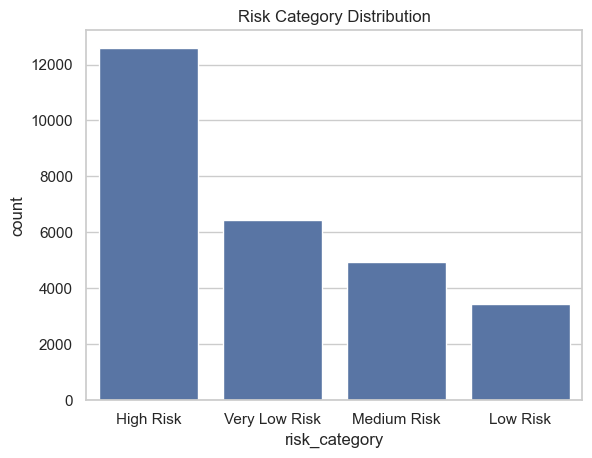

In [354]:
##Step 7: Exploratory Data Analysis (EDA)
sns.countplot(data=master_df, x='risk_category')
plt.title("Risk Category Distribution")
plt.show()


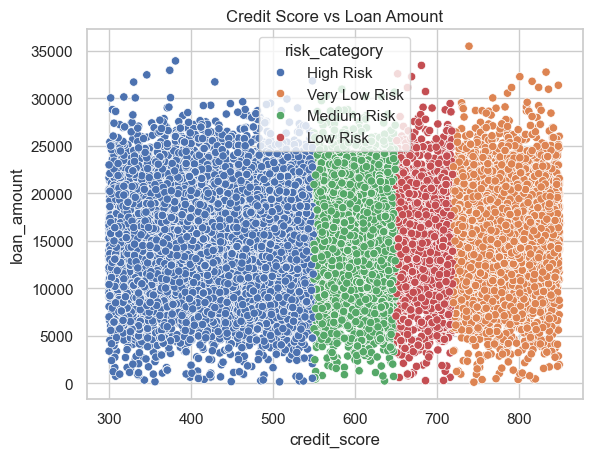

In [454]:
##Credit Score vs Loan Amount

sns.scatterplot(data=master_df, x='credit_score', y='loan_amount', hue='risk_category')
plt.title("Credit Score vs Loan Amount")
plt.show()


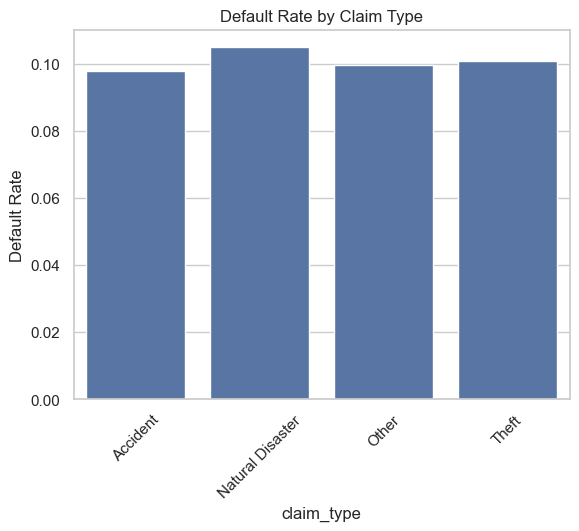

In [456]:
#Default Rate by Claim Type

default_rate = master_df.groupby('claim_type')['default_history'].mean().reset_index()
sns.barplot(data=default_rate, x='claim_type', y='default_history')
plt.title("Default Rate by Claim Type")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.show()


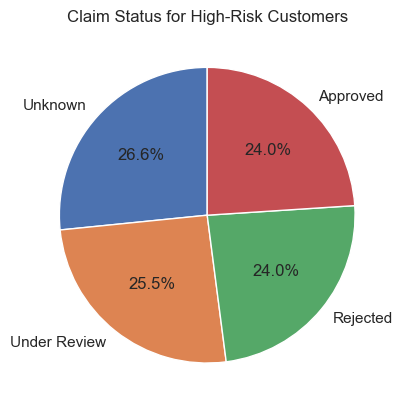

In [458]:
# Claim Status for High-Risk Customers

high_risk = master_df[master_df['risk_category'] == 'High Risk']
claim_status_counts = high_risk['claim_status'].value_counts()
claim_status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Claim Status for High-Risk Customers")
plt.ylabel("")
plt.show()


In [460]:
print(master_df['risk_category'].value_counts())


risk_category
High Risk        12593
Very Low Risk     6431
Medium Risk       4945
Low Risk          3441
Name: count, dtype: int64


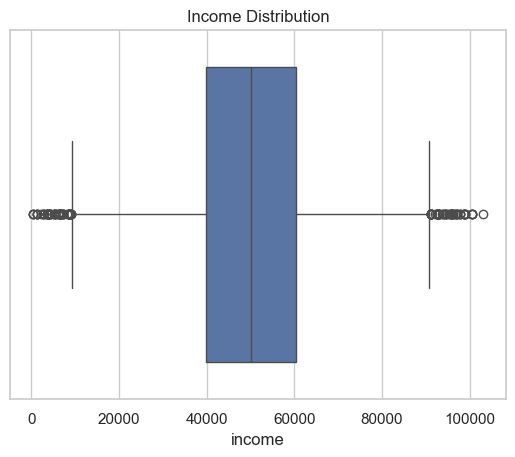

In [462]:
# to checked oultlier through visual..

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=master_df['income'])
plt.title("Income Distribution")
plt.show()


In [468]:
# one oulier can be seen from above box plot graph.to detect outlier from IQR method.

Q1 = master_df['income'].quantile(0.25)
Q3 = master_df['income'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = master_df[(master_df['income'] < lower_bound) | (master_df['income'] > upper_bound)]
print(outliers[['customer_id', 'income']])




       customer_id  income
9            10006   98642
10           10006   98642
11           10006   98642
2084         11519    3701
2085         11519    3701
...            ...     ...
26189        29061   94711
26475        29303    4590
27127        29777   94281
27128        29777   94281
27129        29777   94281

[147 rows x 2 columns]


In [470]:
# Cap the outlier  # Calculate IQR bounds
Q1 = master_df['income'].quantile(0.25)
Q3 = master_df['income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap values outside bounds
master_df['income'] = master_df['income'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
)


In [472]:
# checking for duplicates

duplicates = master_df[master_df.duplicated(subset=['customer_id', 'income'], keep=False)]
print(duplicates)


       customer_id              name  age   income employment_status   region  \
1            10003   Heather Carlson   38  53068.0     Self-Employed     East   
2            10003   Heather Carlson   38  53068.0     Self-Employed     East   
3            10004     Eileen Bright   41  48737.0     Self-Employed     East   
4            10004     Eileen Bright   41  48737.0     Self-Employed     East   
5            10005       Debra Jones   20  48380.0           Student     East   
...            ...               ...  ...      ...               ...      ...   
27404        29996     Alicia Brooks   44  57620.0        Unemployed     West   
27405        29997  Shannon Arellano   41  76296.0           Student  Central   
27406        29997  Shannon Arellano   41  76296.0           Student  Central   
27408        29999   James Dominguez   28  71849.0          Employed     West   
27409        29999   James Dominguez   28  71849.0          Employed     West   

               signup_date 

In [474]:
master_df = master_df.drop_duplicates(subset=['customer_id', 'income'])


In [476]:
#Duplicate validation script

#  Check for full-row duplicates
full_duplicates = master_df[master_df.duplicated()]
print(f"Full-row duplicates found: {len(full_duplicates)}")

#  Check for duplicates based on key columns (e.g., customer_id)
key_duplicates = master_df[master_df.duplicated(subset=['customer_id'], keep=False)]
print(f"Duplicate customer_id entries: {len(key_duplicates)}")

#  Optional: View duplicate rows
if not full_duplicates.empty:
    print("Full duplicates preview:")
    print(full_duplicates.head())

if not key_duplicates.empty:
    print("Customer ID duplicates preview:")
    print(key_duplicates[['customer_id', 'income', 'loan_amount']].head())


Full-row duplicates found: 0
Duplicate customer_id entries: 0


<Axes: xlabel='credit_score', ylabel='loan_amount'>

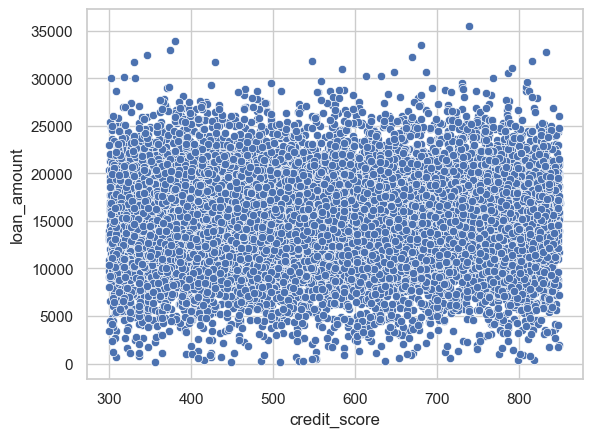

In [478]:
sns.scatterplot(data=master_df, x='credit_score', y='loan_amount')


In [500]:
# KPI....



avg_credit_score = master_df['credit_score'].mean()
approval_rate = (master_df['claim_status'] == 'Approved').mean() * 100
##default_rate = master_df['default_flag'].mean() * 100
high_risk_count = (master_df['risk_category'] == 'High').sum()

print(f"📊 Avg Credit Score: {avg_credit_score:.2f}")
print(f"📊 Claim Approval Rate: {approval_rate:.2f}%")


📊 Avg Credit Score: 573.87
📊 Claim Approval Rate: 20.66%


In [482]:
#Phase 2: SQL – Data Manipulation & Analysis

!pip install python-dotenv mysql-connector-python SQLAlchemy





In [484]:
!pip install pymysql


In [486]:
# Create SQLAlchemy Engine

from sqlalchemy import create_engine

user = "root"
password = "Welcome%402025"
host = "localhost"
db = "master_project"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{db}")




In [488]:
# load data
print("\n Show the total record")
master_df.to_sql('claims_data', con=engine, if_exists='replace', index=False)



 Show the total record


12670

In [490]:
print(master_df.shape)


(12670, 20)


In [496]:
# Export to Excel for tableau dashboard use
master_df.to_excel('cleaned_master_data.xlsx', index=False)


In [498]:
import os
print(os.getcwd())


C:\Users\lalit


In [502]:
print(master_df.columns.tolist())

['customer_id', 'name', 'age', 'income', 'employment_status', 'region', 'signup_date', 'loan_amount', 'credit_score', 'late_payments', 'default_history', 'risk_score', 'risk_level', 'claim_id', 'incident_date', 'claim_amount', 'claim_status', 'claim_type', 'debt_to_income_ratio', 'risk_category']
